# Assignment 4 Task 2

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
# Enable autoreloading if import packages are changed
%load_ext autoreload
%autoreload 2

In [3]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image

plt.rcParams['figure.figsize'] = [20, 12]

'''
ADJUSTABLE PARAMETERS:
downsample_factor: increase to make the loaded images smaller
max_disparity: decrease to consider fewer disparities
'''
downsample_factor = 8 # For the submission, use value of 4
max_disparity = 220 // downsample_factor

## Load and Display Base and Matching Images

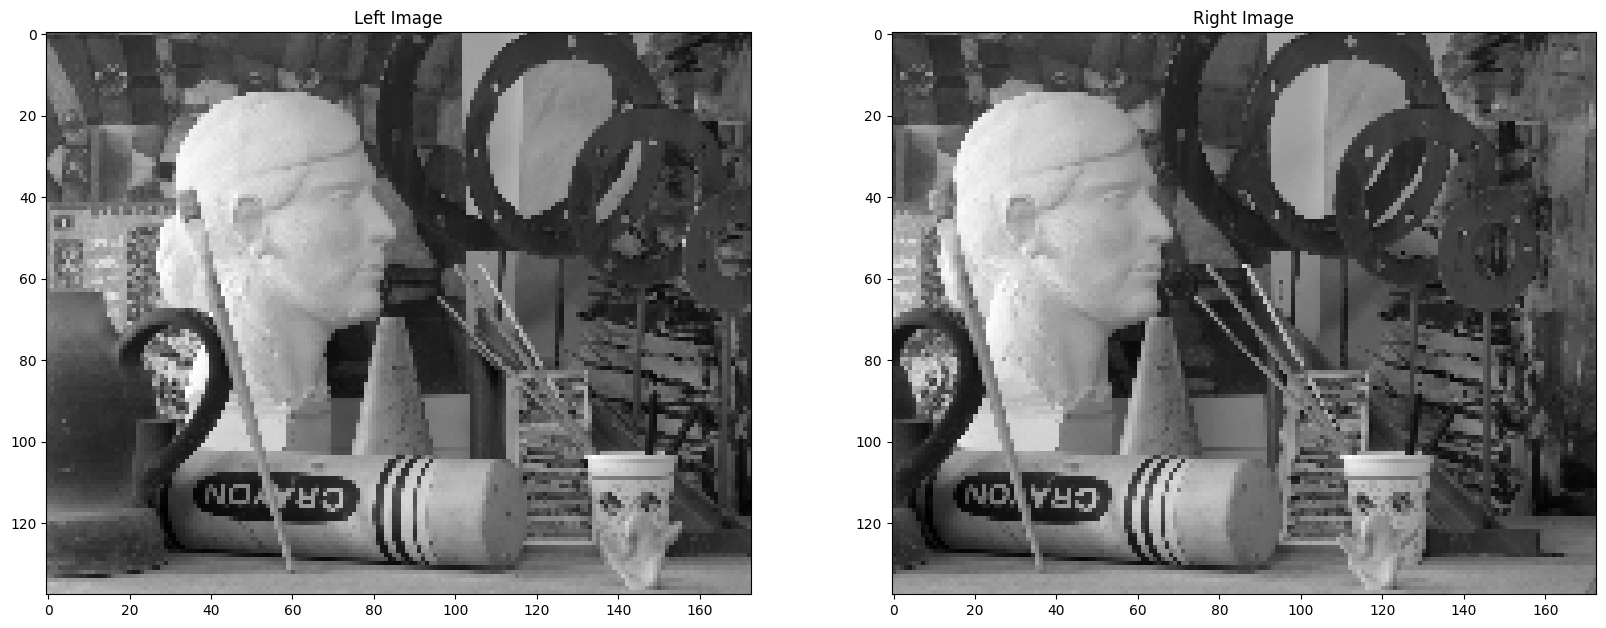

In [4]:
def load_images(image_pair_name, downsample_factor):
    def _load_single_image(image_pair_name, format_number,downsample_factor):
        image_path = os.path.join('Middlebury', image_pair_name, 'view{}.png'.format(format_number))
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if downsample_factor != 1:
            resize_height = image.shape[0] // downsample_factor
            resize_width = image.shape[1] // downsample_factor
            image = cv2.resize(image, (resize_width, resize_height))
        return image
    left = _load_single_image(image_pair_name, 1, downsample_factor)
    right = _load_single_image(image_pair_name, 5, downsample_factor)
    return left, right

def display_single_image(ax,image, title, epipolar_line_y):
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    if epipolar_line_y:
        ax.axhline(y=epipolar_line_y, color='red', linestyle='--', linewidth=2)

def display_images(left, right, epipolar_line_y=None):
    joined_gray = np.concatenate([left, right], axis=1)
    fig, axs = plt.subplots(1,2)
    display_single_image(axs[0],left,'Left Image', epipolar_line_y)
    display_single_image(axs[1],right,'Right Image', epipolar_line_y)
    plt.show()


Il, Ir = load_images("Art", downsample_factor=downsample_factor)
display_images(Il, Ir)

## Define Helper Function: Produce Shifted Image

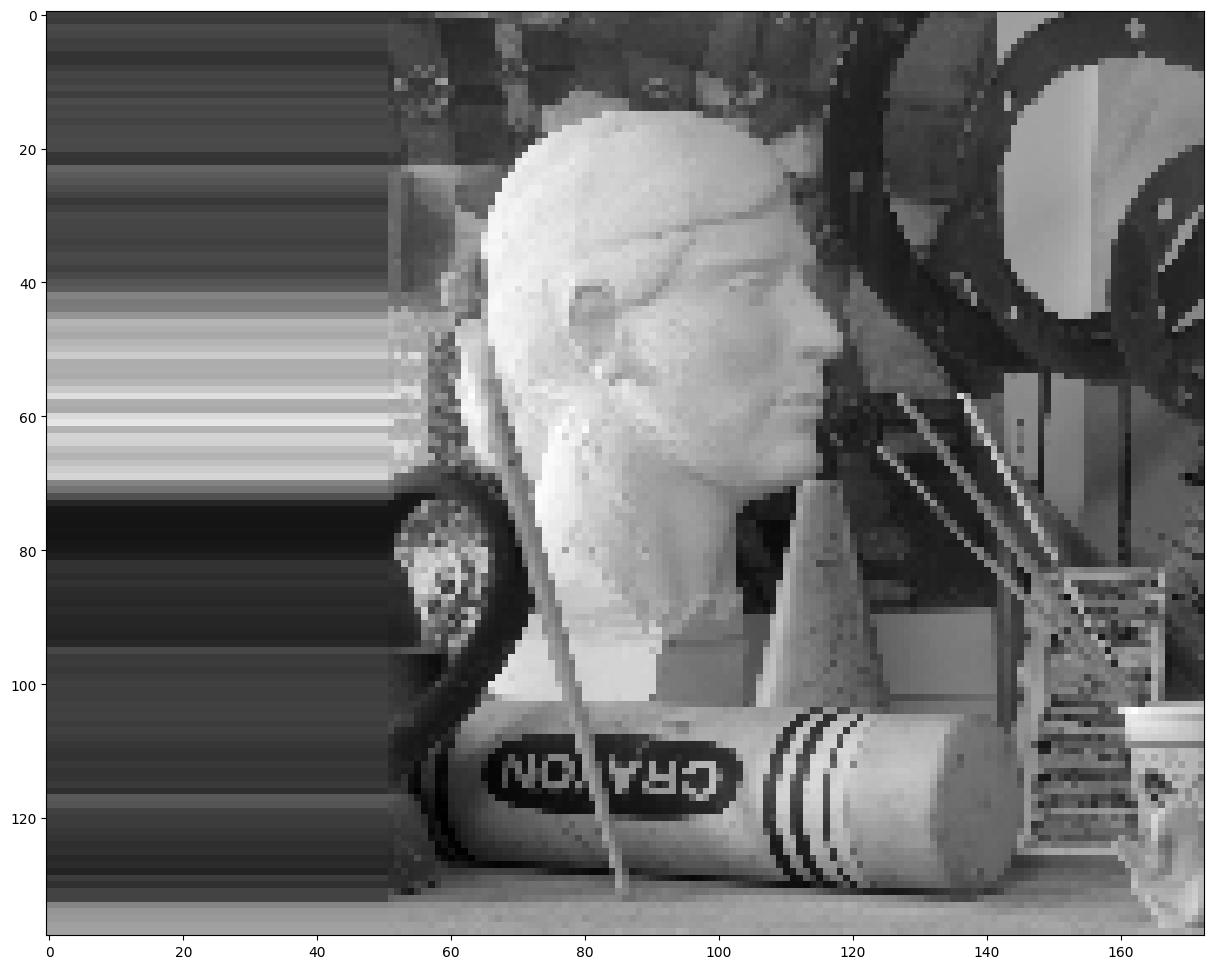

In [5]:

def produce_shifted_image(image, shift_columns):
    '''
    Shift the image to the right. This function is useful for implementing Q1
    Inputs: image: Grayscale, (Height x Width), 
             shift_columns: non negative integer for how far to shift the image to the right
    Output: the image, shifted to the right by shift columns. The rightmost column is copied to maintain the image size. 
    '''

    if shift_columns == 0:
        return image
    first_column = image[:,0]
    shifts = np.tile(first_column, (shift_columns,1)).T
    cut_image=image[:,:-shift_columns]
    image = np.concatenate([shifts,cut_image],axis=1)
    return image

shift = 50
shifted_image = produce_shifted_image(Ir, shift)
plt.imshow(shifted_image, cmap='gray')
plt.show()

## Compute the Data Term (Copy from Task 1 Q1)

In [19]:
def compute_data_term(Il, Ir, max_disparity, patch_size=5):
    '''
    Compute the data term: the RMSE between patches. 
    Input:  left (base) and right (match) image: Grayscale, (Height x Width), 
            max_disparity: non negative integer, the largest disparity value considered by the data term
            patch_size: non_negative, odd, integer. RMSE will be calculated in a window of 
            dimensions (patch_size, patch_size) centered around the point of interest.
    Output: data_term: a (height x Width x max_disparity) numpy matrix, storing all of the rmse for 
            all considered disparities at all pixels. More concretely, the value of data_term[y,x,d] will be 
            the RMSE of matching point (y,x) of the base image to point (y, x-d) of the matching image
            In cases where the window for RMSE goes out of frame, you can assume reflecting boundary conditions.
    '''
    ######################################################################################################
    # TODO Q1: Implement the data term                                                                   #
    # See lecture 6 part B slide 4                                                                       #
    ######################################################################################################
    
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****  
    h, w  = Il.shape  
    r = (patch_size-1)//2
    data_term = np.zeros((h, w, max_disparity))
    
    for y in range(r, h - r):
        for x in range(r, w - r):
            # Define the patch in the left image
            patch_left = Il[y-r:y+r+1, x-r:x+r+1]
            for d in range(max_disparity):
                if x-r-d >= 0:
                    patch_right = Ir[y-r:y+r+1, x-r-d:x+r+1-d]
                # Calculate RMSE and store in data_term
                rmse = np.sqrt(np.mean((patch_left - patch_right)**2))
                data_term[y, x, d] = rmse
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return data_term

## Q1: Implement 2D Version in C++

In [ ]:
# 
# The C-code is in sgm.ccp 
# Use ./compile.sh to compile it 
# PLEASE NOTE: The C-code is compiled into an .so file. In order to use it here you need to reload your kernel.
# For every test run, please do "Kernel -> Restart & Run All"
#
import os
import sys 
sys.path.append("build")

def sgm(data_term, P1=1, P2=5):
    from numpy.ctypeslib import ndpointer
    import ctypes
    import numpy as np

    # Load .so file 
    library_path = os.path.abspath('./build/libsgm.dylib')
    lib = ctypes.cdll.LoadLibrary(library_path)

    # Set up C function call 
    c_sgm = lib.sgm
    c_sgm.restype = None
    c_sgm.argtypes = [ndpointer(ctypes.c_double, flags='C_CONTIGUOUS'),
                      ndpointer(ctypes.c_double, flags='C_CONTIGUOUS'),
                      ndpointer(ctypes.c_uint8, flags='C_CONTIGUOUS'),
                      ctypes.c_int,
                      ctypes.c_int,
                      ctypes.c_int,
                      ctypes.c_float,
                      ctypes.c_float
                    ]

    # Convert data term to contigous array 
    cont_data_term = np.ascontiguousarray(data_term, np.float64)
    
    # Allocate output arrays 
    height, width = Il.shape[0], Il.shape[1]
    disparities = np.ascontiguousarray(np.zeros((height, width), dtype=np.uint8))
    messages = np.ascontiguousarray(np.zeros((8, height, width, max_disparity), dtype=np.float64))

    # Call the C function
    c_sgm(cont_data_term, messages, disparities, width, height, max_disparity, P1, P2)

    # Return values 
    # Messages are returend only for debugging purposes 
    return disparities, messages

# Compute data term  
patch_size = 5 
data_term = compute_data_term(Il, Ir, max_disparity, patch_size)

# Call SGM C-code 
disparities, messages = sgm(data_term)

# Visualize result 
plt.figure() 
plt.imshow(disparities, cmap='gray')
plt.show()